In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
from decode_fish.engine.microscope import add_pos_noise
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import window_predict
from decode_fish.funcs.exp_specific import *
from decode_fish.funcs.evaluation import matching
import kornia

from omegaconf import open_dict
from hydra import compose, initialize

initialize(config_path="../config")

hydra.initialize()

In [3]:
# import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training
Data taken from https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/

In [4]:
def README():
    # This data collection contains spatially resolved single-cell transcriptomics datasets acquired using MERFISH on the mouse primary motor cortex (MOp) collected by the Xiaowei Zhuang Lab at Harvard University and Howard Hughes Medical Institute.

    # * The dataset contains MERFISH images of 12 experiments, which include 64 coronal slices of the MOp region (10 um thick slices, every 100um interval) collected from 2 biological replicates. For each mouse, 6 experiments were performed, and each experiment was named with the mouse id plus the sample id, e.g. mouse1_sample1, mouse2_sample3. For each experiment, multiple coronal slices (4-6 slices) were included on the same coverslip and were imaged together.

    # * In this dataset, a total of 258 genes were imaged. Among the 258 genes, 242 genes were imaged using MERFISH, which encodes individual genes with error-robust barcodes (22-bit binary codes in this case), imprints the barcodes onto the RNAs using combinatorial labeling with encoding probes, and measures the barcodes bit-by-bit using sequential hybridization of readout probes. The 22 bits are imaged in 11 hybridization rounds with two-color imaging each round. The remaining 16 genes were imaged by 8 sequential rounds of two-color FISH.

    # * Each of the subdirectory folders contains either the raw (e.g. mouse1_sample1_raw) or processed images (e.g. mouse1_sample1_processed) of one experiment. Each experiment contains many fields of view (FOVs) and each tiff file in the folder corresponds to the images of one FOV. The raw image files are named as aligned_images plus the FOV id (e.g. aligned_images0.tif); the processed image files are named as processed_images plus the FOV id (e.g. processed_images100.tif).

    # â€¢	{sample_id}_raw: folders containing raw images. Each raw image file, corresponding to one FOV, is a stacked tiff file of multiple frames, each frame corresponding to one z-plane of one channel and each channel corresponding to one bit of the MERFISH imaging process, or one gene imaged in the sequential hybridization process, or the DAPI and polyT images used for cell segmentation. Seven z-planes are imaged for each channel. Images are aligned by fiducial bead fitting across each imaging round. The tiff stacks are ordered as channel 1 z-planes 1 through 7, channel 2 z-planes 1 through 7, â€¦, channel 40 z-plane 1 through 7. See data_organization_raw.csv file for detailed channel information.

    # â€¢	{sample_id}_processed: folders containing processed images. Each processed image file, corresponding to one FOV, is a stacked tiff file of multiple frames, each frame corresponding to one z-plane of one channel and each channel corresponding to one bit of the MERFISH imaging process, or the DAPI and polyT images used for cell segmentation. Seven z-planes are imaged for each channel. Images are aligned by fiducial bead fitting across each imaging round, and processed with a high pass filter and deconvolution. The tiff stacks are ordered the same as the raw images, except that images for the genes imaged by straight sequential hybridization are not included. See data_organization_processed.csv file for detailed channel information, and preprocessing.json file for parameters used in image processing. 
    # Note: For the 650 nm channels, a significant number of spots observed the first z-plane (i.e. at the coverslip surface) correspond to non-specific binding of the 650 nm dye to the coverslip surface, and the vast majority of these non-specific binding spots are decoded as invalid barcodes in the decoding process and are not used for subsequent analysis.  

    # * The processed_data folder contains the following files:
    # â€¢	segmented_cells_{sample_id}.csv: Segmented cell boundary coordinates of each z-plane and the slice id that each cell belongs to for each experiment. Note that each experiment includes 4-6 tissue slices on a single coverslip, and the slice id gives the slice number that the cells belong to.
    # â€¢	spots_{sample_id}.csv: Decoded spot location (x,y,z) in the unit of microns and their target gene identity for each experiment. The same coordinate system was used in segmented_cells_{sample_id}.csv and spots_{sample_id}.csv for each experiment, and hence the spots can be parsed into the segmented cells (and also the slices) according by comparison of their coordinates with the cell boundary locations.  
    # â€¢	counts.h5ad: Cell by gene matrix of the whole dataset. The counts are normalized by the volume of each cell.
    # â€¢	cell_labels.csv: Cluster label assignment for each cell.

    # We also provide these files that are associated to this dataset:
    # â€¢	genes_combinatorial.txt: List of target genes that are imaged in combinatorial imaging rounds.
    # â€¢	genes_sequential.txt: List of target genes that are imaged sequentially after the combinatorial imaging rounds.
    # â€¢	probes.fasta: Provides sequences all encoding probes used for hybridization.
    # â€¢	codebook.csv: Provides the barcodes that encode individual genes measured in the combinatorial imaging rounds.
    # â€¢	data_organization_raw.csv: Provides information on how individual channels and z-planes are ordered in the multi-frame tiff file for each field of view of raw images.
    # â€¢	data_organization_processed.csv: Provides information on how individual channels and z-planes are ordered in the multi-frame tiff file for each field of view of processed images.
    # â€¢	microscope.json: Provides parameters of the microscope that was used with pixel size and orientation of images.
    # â€¢	preprocessing.json: Provides values and filters used in generating the processed images.
    # â€¢	fov_positions folder: contains the txt files of field of view positions for individual samples, named by its sample id.
    
    return

Own Notes: z-bins given in data_organization_raw.csv: 0.,1.5,3.,4.5,6.,7.5,9.

Values in the the prediction files: 0., 1.38248848, 2.76497696, 4.14746544, 5.52995392, 6.9124424 , 8.29493088

1.4 um would correspond to 13 pixels in x-y

In [1390]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_MOp"])
# cfg = OmegaConf.create(cfg)

Make dataset specific changes

In [1391]:
# thetas = [79.11,20.9942,11.0078,41.7738,31.2776,14.7114,37.665,9.66,11.956,23.7223,26.4227,8.6138,46.759,4.8934,9.4187,47.1626,26.786,6.9419,28.795,11.7935,5.9558,23.017]
# thetas = [t / 10 for t in thetas]
# channels_facs = [t / min(thetas) for t in thetas]
# thetas = [17.34,13.09,9.42,11.71,8.80,11.20,10.84,7.86,9.15,7.61,8.17,7.60,12.23,4.89,8.04,12.02,8.30,6.04,8.53,8.91,5.82,7.38]
thetas = [3.44,3.19,2.12,1.91,2.62,3.01,2.95,2.80,3.47,3.08,2.17,2.67,2.98,2.13,3.46,2.88,2.50,2.77,2.71,4.32,2.77,2.71]
thetas = [t / 2 for t in thetas]
channel_facs = [1. / i for i in [6.06987595, 1.82478585, 1.53286355, 4.8872792 , 3.85842224, 1.39192186, 3.59428667, 1.14721266, 1.13473409, 2.7379446 , 3.61746085, 1.12158215, 3.86871193, 0.93670706, 1.05856023, 3.59824101, 3.1697511 , 0.96464653, 2.96241304, 0.97365983, 0.85356345, 2.97999459]] 

In [1392]:
cfg.output.project = 'MERFISH_MOp'
# cfg.output.group='sweep_sl_4'
# cfg.sub_name='scaled'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif'

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.genm.foci.n_foci_avg = 1
# Lower and upper limit of emitters simulated per focus
cfg.genm.foci.n_mol_range: [5,40]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 
cfg.genm.prob_generator.low = 0.0002
cfg.genm.prob_generator.high = 0.05

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.network.f_maps = 384
cfg.network.depth = 2
cfg.network.n_out_l = 1
cfg.training.bs = 10

cfg.genm.noise.theta = thetas
cfg.genm.microscope.ch_facs = channel_facs

cfg.sim.roi_mask.percentile = 20
cfg.sim.random_crop.crop_sz = 56

cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9

cfg.genm.intensity_dist.int_conc = 4
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = .1

cfg.training.num_iters = 40000
cfg.training.int.enabled = False
cfg.training.mic.enabled = False

cfg.genm.microscope.scale = 400
cfg.genm.phasing = 0.0
cfg.sim.bg_estimation.fractal.scale = 0

cfg.run_name ='MERFISH_mop_23'
cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf2n.tif'

cfg.genm.microscope.norm = 'none'

cfg.training.mic.mean_diff = False

cfg.training.mic.par_grads.channel_facs = True
cfg.training.mic.par_grads.channel_shifts = False
cfg.training.mic.par_grads.theta_par = False
cfg.training.mic.par_grads.psf_vol = True
cfg.training.mic.par_grads.color_shifts = True
cfg.training.mic.par_grads.z_facs = True

cfg.training.net.enabled = True

cfg.training.start_mic = 10000
cfg.training.start_int = 100000

cfg.output.log_interval = 600

cfg.genm.emitter_noise.rate_fac = 3.
cfg.genm.emitter_noise.int_fac = 1.

cfg.training.net.opt.lr = 3e-4
cfg.training.z_sig_fac = 1.

cfg.evaluation.code_stats.enabled = True
cfg.training.schedule = None #[10000, 3000, 5000, 2000, 5000, 2000, 5000, 2000, 10000]
cfg.network.chrom_map = True

cfg.training.mic.opt.lr = 0.00025
cfg.training.mic.sched.step_size = 2000

cfg.data_path.model_init  = None
# cfg.data_path.micro_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_8d/start_mic:0xenabled:Falsexl1_reg:0.0003xpsf_vol:Truextheta_par:True/microscope_wcolshifts.pkl' 
# cfg.data_path.micro_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_11/color_shifts:True//microscope.pkl'
# cfg.data_path.model_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_22/num_iters:9995xz_sig_fac:1.0xmodel_init:null//'
cfg.data_path.micro_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_22/seed:3xnorm:nonexmodel_init:nullxmean_diff:True/microscope.pkl'
cfg.genm.exp_type.const_theta_sim = True

cfg.training.net.bl_loss_scale = 0.003
cfg.network.is_2D = True

cfg.genm.noise.sim_scale = 1.

In [1393]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_mop_23'

In [1395]:
!nvidia-smi

Tue May 10 10:26:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVS 510             Off  | 00000000:02:00.0 N/A |                  N/A |
| 28%   42C    P8    N/A /  N/A |    628MiB /  1998MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 39%   

In [29]:
# fname = f'../config/experiment/{cfg.run_name}_psf.yaml'
# OmegaConf.save(cfg, fname)
# prepend_line(fname, '# @package _global_')
# fname

In [30]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name=num_iters:9995')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_mop_20 run_name=num_iters:9995


Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [691]:
n_foci = cfg.genm.foci.n_foci_avg
cfg.genm.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
cfg.genm.foci.n_foci_avg = n_foci
psf, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


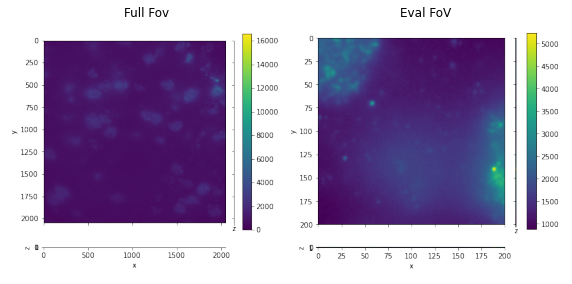

In [570]:
fig1, axes = plot_3d_projections(img_3d[0][5], size=5, proj_func=np.max, display=False)
sl = eval(cfg.evaluation.reconstruction.crop_sl,{'__builtins__': None},{'s_': np.s_})
fig2, axes = plot_3d_projections(img_3d[0][sl][5], size=5, display=False)
_ = combine_figures([fig1,fig2], titles=['Full Fov', 'Eval FoV'])

In [571]:
# plot_channels(img_3d[0][sl], 2, display=False, vmax=20000)

In [2318]:
# img = load_tiff_image(cfg.data_path.image_path)
thetas = []
for i in range(22):
    bg_est = hydra.utils.instantiate(cfg.sim.bg_estimation.smoothing)(img_3d[0][i,:,:500,1500:].to('cuda'))
    theta = estimate_noise_scale(img_3d[0][i,:,:500,1500:], bg_est, percentile=99, plot=False)
    plt.show()
    thetas.append(theta)

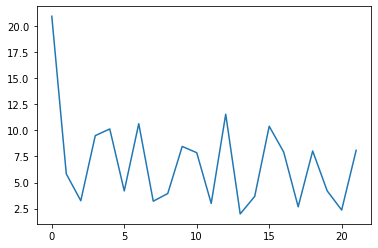

In [2319]:
plt.plot(thetas)

In [774]:
# get_simulation_statistics(decode_dl, micro, **cfg.genm.intensity_dist, int_threshold=0.1, samples=10, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, psf_noise=False)

# Evaluation

In [1382]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_6a/pos_noise_xy:0.5xpos_noise_z:0.2xpsf_vol:False/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_8d/start_mic:0xenabled:Falsexl1_reg:0.0003xpsf_vol:Truextheta_par:True/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_13/seed:3/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_14/scale:400.0xnorm:nonexfac:1.0//train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_22c/net:2xmicro:3//train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_12b/lr:0.00025xstep_size:2000//train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/gensweep_mop_1/norm:nonexz_facs:Truexmean_diff:True/train.yaml')

In [1383]:
code_ref, targets = hydra.utils.instantiate(cfg.codebook)

In [1384]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(code_ref)

RuntimeError: Error(s) in loading state_dict for UnetDecodeNoBn:
	Missing key(s) in state_dict: "outnet.p_out_l.0.weight", "outnet.p_out_l.0.bias", "outnet.p_out_l.2.weight", "outnet.p_out_l.2.bias", "outnet.xyzi_out_l.0.weight", "outnet.xyzi_out_l.0.bias", "outnet.xyzi_out_l.2.weight", "outnet.xyzi_out_l.2.bias", "outnet.xyzis_out_l.0.weight", "outnet.xyzis_out_l.0.bias", "outnet.xyzis_out_l.2.weight", "outnet.xyzis_out_l.2.bias", "outnet.bg_out_l.0.weight", "outnet.bg_out_l.0.bias", "outnet.bg_out_l.2.weight", "outnet.bg_out_l.2.bias", "network.1.p_out_l.0.weight", "network.1.p_out_l.0.bias", "network.1.p_out_l.2.weight", "network.1.p_out_l.2.bias", "network.1.xyzi_out_l.0.weight", "network.1.xyzi_out_l.0.bias", "network.1.xyzi_out_l.2.weight", "network.1.xyzi_out_l.2.bias", "network.1.xyzis_out_l.0.weight", "network.1.xyzis_out_l.0.bias", "network.1.xyzis_out_l.2.weight", "network.1.xyzis_out_l.2.bias", "network.1.bg_out_l.0.weight", "network.1.bg_out_l.0.bias", "network.1.bg_out_l.2.weight", "network.1.bg_out_l.2.bias". 
	Unexpected key(s) in state_dict: "outnet.p_out1.weight", "outnet.p_out1.bias", "outnet.p_out2.weight", "outnet.p_out2.bias", "outnet.xyzi_out1.weight", "outnet.xyzi_out1.bias", "outnet.xyzi_out2.weight", "outnet.xyzi_out2.bias", "outnet.xyzis_out1.weight", "outnet.xyzis_out1.bias", "outnet.xyzis_out2.weight", "outnet.xyzis_out2.bias", "outnet.bg_out1.weight", "outnet.bg_out1.bias", "outnet.bg_out2.weight", "outnet.bg_out2.bias", "network.1.p_out1.weight", "network.1.p_out1.bias", "network.1.p_out2.weight", "network.1.p_out2.bias", "network.1.xyzi_out1.weight", "network.1.xyzi_out1.bias", "network.1.xyzi_out2.weight", "network.1.xyzi_out2.bias", "network.1.xyzis_out1.weight", "network.1.xyzis_out1.bias", "network.1.xyzis_out2.weight", "network.1.xyzis_out2.bias", "network.1.bg_out1.weight", "network.1.bg_out1.bias", "network.1.bg_out2.weight", "network.1.bg_out2.bias". 

In [1354]:
fov = 47
crop = np.s_[:,:,:,500:1750,500:1750]

bench_df = get_mop_benchmark(z_to_batch=True)
bench_df = get_mop_fov(bench_df, fov)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70

bench_df = crop_df(bench_df, crop[-4:], px_size_zyx=[100., 100., 100.])   

17130008


In [1347]:
image_vol = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif', scaled=False, z_to_batch=True)

In [1348]:
mult = micro.get_ch_mult()
# new_facs = torch.tensor([1.1071, 1.1146, 1.1594, 1.1228, 1.1569, 1.1133, 1.0660, 1.1222, 1.0468,
#         1.1190, 1.2314, 1.1649, 1.1000, 1.0652, 1.1173, 1.1794, 1.1963, 1.1046,
#         1.1807, 1.1417, 1.1818, 1.1437]).cuda()
# mult = (new_facs * (len(new_facs) / new_facs.sum()) * micro.ch_scale)[None,:,None,None,None]

In [1355]:
res_df = window_predict(model, post_proc, image_vol, window_size=[None, 64, 64], device='cuda', crop=crop, chrom_map=get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx)[:,:,None], scale=mult, progress_bar=True)
res_df['gene'] = targets[res_df['code_inds']]
res_df = remove_doublets(res_df, 200)

if len(res_df):

    res_sub = res_df.nsmallest(len(bench_df), 'comb_sig')
    
    bench_counts = DF(data=None, index=targets)
    bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
    bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
    bench_counts = bench_counts.fillna(0)

    r = np.corrcoef(bench_counts['Bench_all'].values, bench_counts['Res_all'].values)[0, 1]   

    blinds = []
    for i,g in enumerate(targets):
        if 'Blank' in g:
            blinds.append(g)

    bc = bench_counts.loc[blinds,'Res_all'].values.sum()
    bench_bc = bench_counts.loc[blinds,'Bench_all'].values.sum()

#     bench_df['z'] = bench_df['z']/1000
#     res_sub['z'] = res_sub['z']/100

    print('AE Losses/code_bench_corr', r)
    print('AE Losses/N_blanks', bc/bench_bc)

    perf_dict, match_df, shifts = matching(bench_df,  res_sub, tolerance=500)
    print('AE Losses/jaccard', perf_dict['jaccard'])        

print('AE Losses/N_pred_tot', len(res_df)/len(bench_df))

torch.Size([7, 22, 1, 2048, 2048])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:34<00:00, 22.06s/it]


AE Losses/code_bench_corr 0.9936647012592302
AE Losses/N_blanks 0.7959183673469388
Recall: 0.761
Precision: 0.761
Jaccard: 61.468
RMSE_vol: 85.628
Eff_3d: 42.400
FN: 8744.0 FP: 8744.0
Num. matches: 27898.000
Shift: 52.85,16.28,-7.11
AE Losses/jaccard 0.6146829391676598
AE Losses/N_pred_tot 1.4697887669887015


In [1359]:
len(bench_df)

36642

In [1360]:
bench_bc

49.0

0.6117007125261086


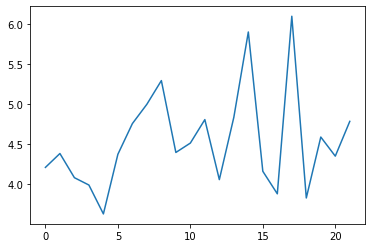

In [1312]:
int_arr = zero_int_ch(res_df, code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
print(np.sqrt(np.var(ch_means)))
plt.plot(ch_means)

0.6117007125261086


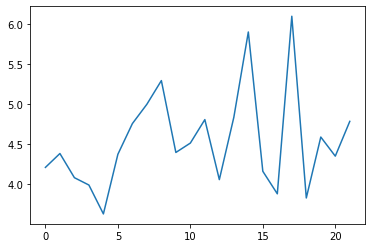

In [1313]:
int_arr = zero_int_ch(res_df, code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
print(np.sqrt(np.var(ch_means)))
plt.plot(ch_means)

In [1327]:
# psf, noise, micro = load_psf_noise_micro(cfg)
micro.load_state_dict(torch.load(cfg.output.save_dir + '/microscope.pkl'), strict=False)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)

1.1037266


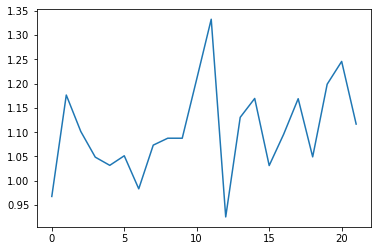

In [1315]:
plt.plot(cpu(micro.channel_facs))
print(cpu(micro.channel_facs).mean())

1.0712572


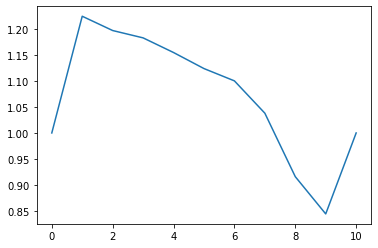

In [1328]:
plt.plot(cpu(micro.z_facs))
print(cpu(micro.z_facs).mean())

In [1317]:
def plot_aberation_map(img):
    plt.figure(figsize=(12,6))
    for j in range(2):
        plt.subplot(1,2,j+1)
        im = plt.imshow(img[0,j,:,:])
        add_colorbar(im)

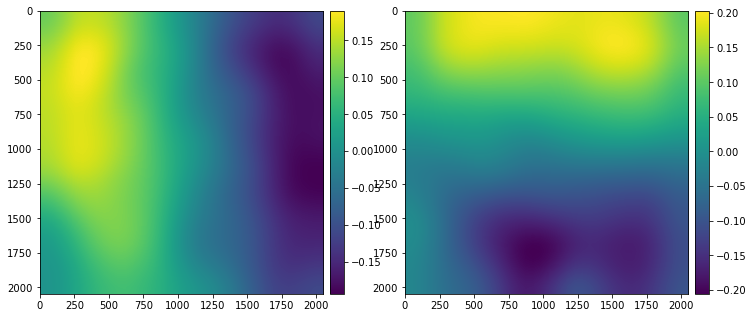

In [1318]:
colshift_inp = cpu(get_color_shift_inp(micro.color_shifts))
plot_aberation_map(colshift_inp)

Plot mean projections of the PSF before and after optimizing it during training

(tensor(3.1588, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0259, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0092, device='cuda:0', grad_fn=<DivBackward0>))


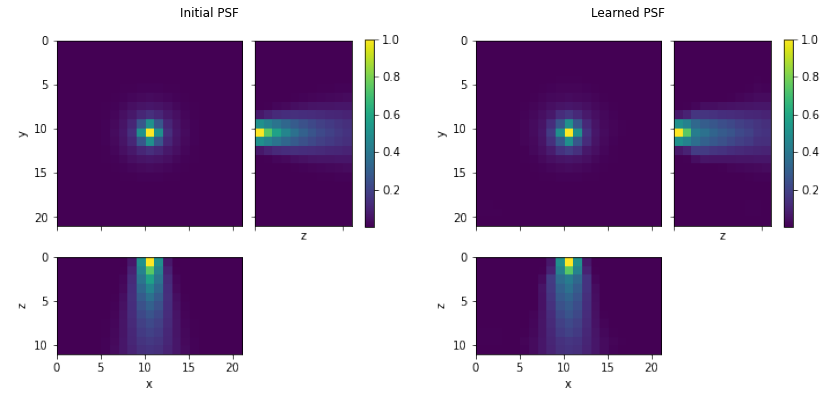

In [1101]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init[0], proj_func=np.max, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol[1], proj_func=np.max, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(15,7))

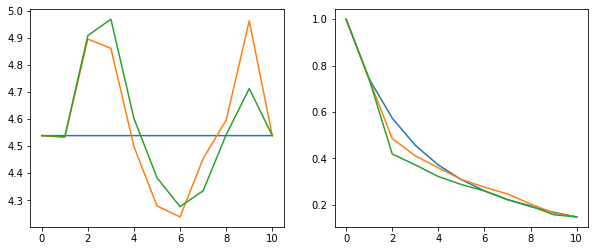

In [1102]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(psf_init[0].sum(-1).sum(-1))
plt.plot(psf_vol[0].sum(-1).sum(-1))
plt.plot(psf_vol[1].sum(-1).sum(-1))
plt.subplot(122)
plt.plot(psf_init[0].max(-1).max(-1))
plt.plot(psf_vol[0].max(-1).max(-1))
plt.plot(psf_vol[1].max(-1).max(-1))

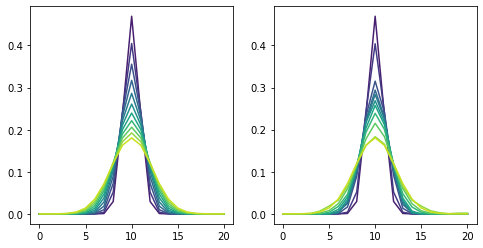

In [1103]:
import seaborn as sns
cpal = sns.color_palette("viridis", n_colors=11)
plt.figure(figsize=(8,4))
plt.subplot(121)
for i in range(len(psf_init[0])):
    plt.plot(psf_init[0,i,10]/psf_init[0,i,10].sum(), color=cpal[i])
plt.subplot(122)
for i in range(len(psf_init[0])):
    plt.plot(psf_vol[0,i,10]/psf_vol[0,i,10].sum(), color=cpal[i])

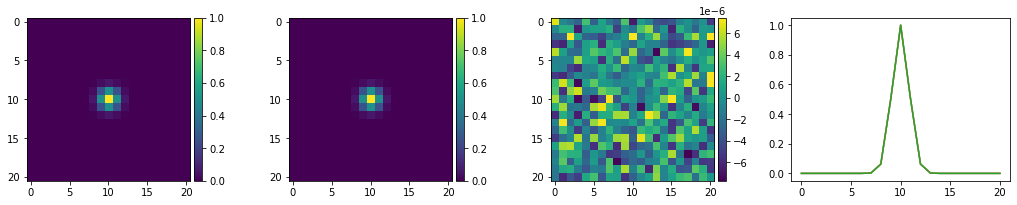

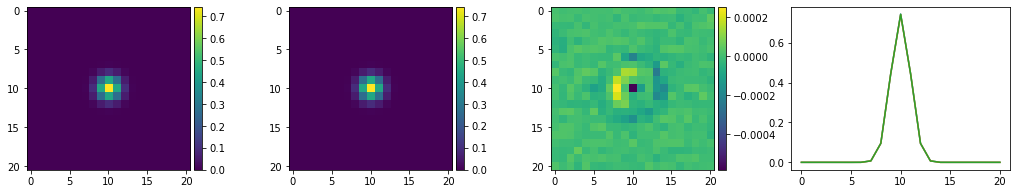

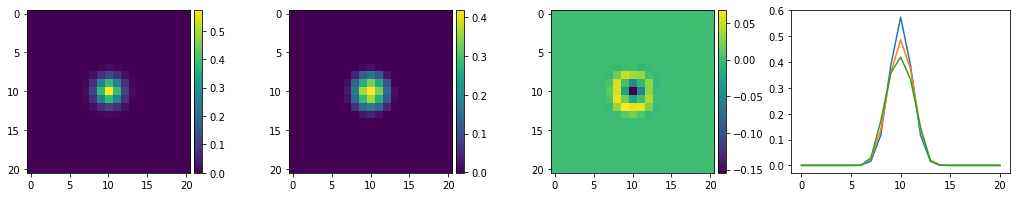

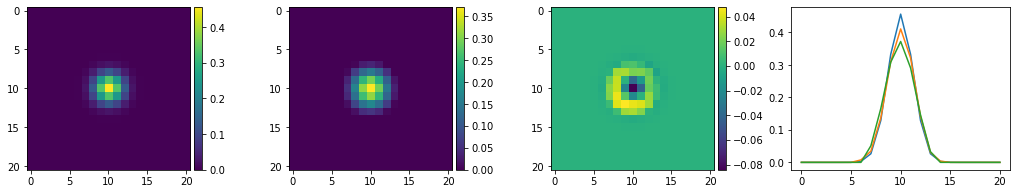

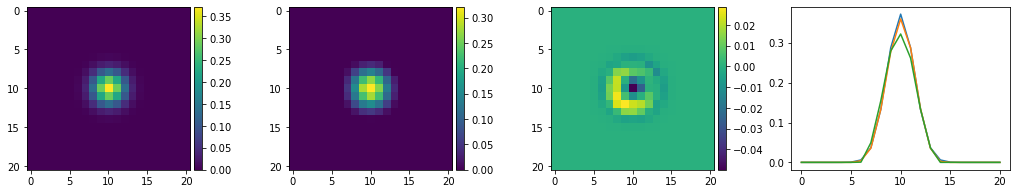

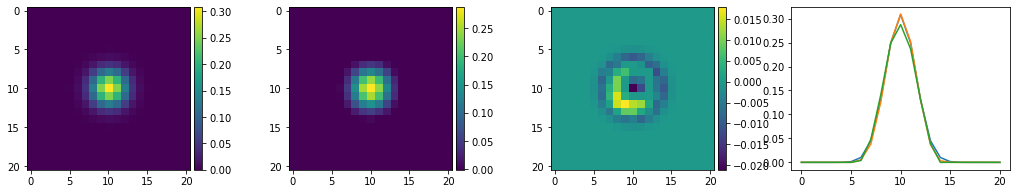

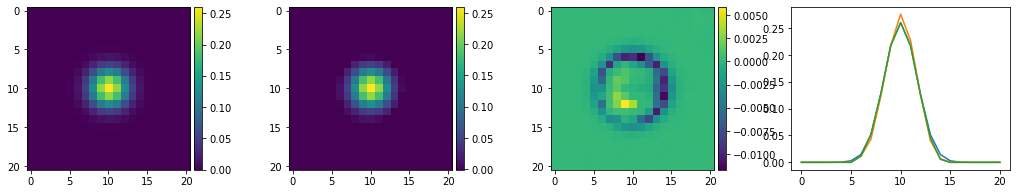

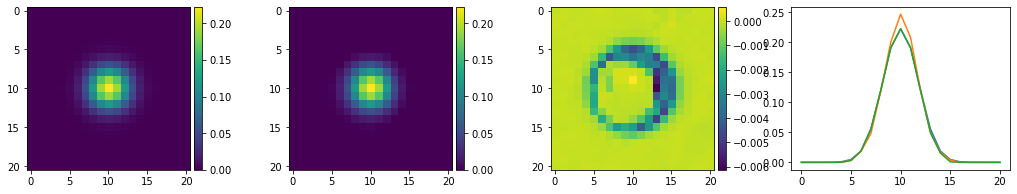

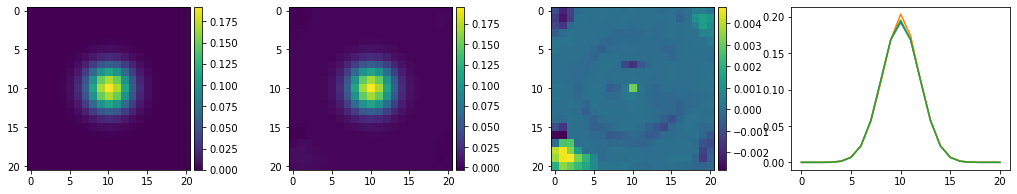

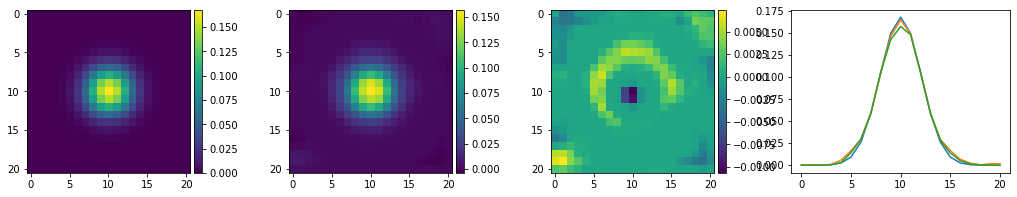

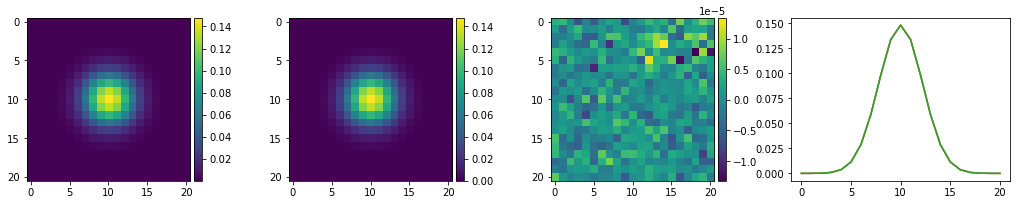

In [1104]:
for i in range(len(psf_init[0])):
    plt.figure(figsize=(18,3))
    plt.subplot(141)
    im = plt.imshow(cpu(psf_init)[0,i])
    add_colorbar(im)
    plt.subplot(142)
    im = plt.imshow(cpu(psf_vol)[1,i])
    add_colorbar(im)
    plt.subplot(143)
    im = plt.imshow(cpu(psf_vol-psf_init)[1,i])
    add_colorbar(im)
    plt.subplot(144)
    plt.plot(psf_init[0,i,10])
    plt.plot(psf_vol[0,i,10])
    plt.plot(psf_vol[1,i,10])
    plt.show()

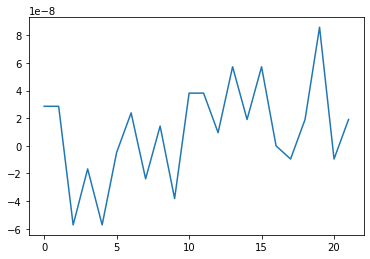

In [303]:
# plt.plot(cpu(micro.noise.theta_par.to('cpu')*micro.noise.theta_scale))
plt.plot(cpu(micro.noise.theta_par.to('cpu')*micro.noise.theta_scale)-thetas)

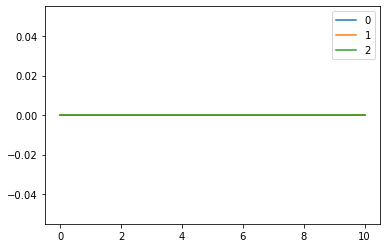

In [707]:
for i in range(3):
    plt.plot(cpu(micro.channel_shifts[:,i]), label=i)
plt.legend()
# plt.plot(np.array(cfg.genm.microscope.ch_cols[:22])*0.2)

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

In [307]:
x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = eval_random_crop(decode_dl, model, post_proc, micro, plot='rec', crop_sz_xy=100, ret_preds=True)
print(len(pred_df))
# eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=100, ret_preds=True)

17


AttributeError: 'tuple' object has no attribute 'shape'

In [721]:
# for i in range(len(psf_recs)):
#     print(cpu(ch_inp[0][1][i]), cpu(ch_inp[3][i]), cpu(ch_inp[4][i]))
#     plt.figure(figsize=(10,3))
#     plt.subplot(131)
#     im = plt.imshow(cpu(psf_recs)[i,0,0])
#     add_colorbar(im)
#     plt.subplot(132)
#     im = plt.imshow(cpu(rois)[i,0,0]-cpu(psf_bgs)[i,0,0])
#     add_colorbar(im)
#     plt.subplot(133)
#     im = plt.imshow(cpu(rois)[i,0,0]-(cpu(psf_recs)[i,0,0]+cpu(psf_bgs)[i,0,0]))
#     add_colorbar(im)
#     plt.show()

In [722]:
# _ = plot_channels(cpu(x[0]), n_rows=4, dfs=[pred_df], codebook=code_ref, vmax=5000)

In [1054]:
decode_dl.dataset.rate_tfms[1].n_foci_avg = 0

In [1073]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True, codebook=None):
    
    gt_dfs = []
    xsim_col = []
    cols_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            background = background * micro.get_ch_mult()
            local_rate *= 2
            
            sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z, codebook=codebook, int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten()))
            ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
            xsim = micro(*ch_inp, add_noise=True)


            noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                           int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                           sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                           sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

            noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
            xsim += micro(*noise_inp, add_noise=True)
        
            x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

            if micro.col_shifts_enabled:
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
                net_inp = torch.concat([x,colshift_crop], 1)
                cols_col.append(colshift_crop)
                
            xsim_col.append(x)

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), torch.cat(cols_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
#             pred_df, rec, res_dict, _, _, _, _ = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_df = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=False)
            pred_dfs.append(pred_df)
#             x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
#     xrec = torch.cat(x_recs)
#     pred_df['z'] = pred_df['z']/100
#     gt_df['z'] = gt_df['z']/100

    perf, matches, _ = matching(gt_df, pred_df, tolerance=1000, print_res=print_res, match_genes=True, allow_multiple_matches=True)
#     perf['mae'] = abs(xrec-rec).mean().item()
#     perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    res_dict = None
    return perf, pred_df, matches, res_dict

In [1305]:
# Load the model, post processing, imgages, dataloader
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_22/seed:3xnorm:nonexmodel_init:nullxmean_diff:True//train.yaml')
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(code_ref)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


In [1296]:
# from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, 50, micro, model, channels=22, n_bits=4, sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref[:242]))
# perf, pred_df, matches, res_dict = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)pred_df

In [1297]:
# perf, pred_df, matches, res_dict = get_sim_perf(torch.concat([xsim,cols*0], 1), px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

In [1298]:
# pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = get_prediction(model, post_proc, torch.concat([xsim[:2],cols[:2]], 1), micro=micro, cuda=True, return_rec=True)

In [1299]:
perf, pred_df, matches, res_dict = get_sim_perf(torch.concat([xsim,cols], 1), px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.311
Precision: 0.910
Jaccard: 30.204
RMSE_vol: 81.272
Eff_3d: 19.236
FN: 69320.0 FP: 3107.0
Num. matches: 31342.000
Shift: -0.21,-0.38,5.50


In [1306]:
perf, pred_df, matches, res_dict = get_sim_perf(torch.concat([xsim,cols], 1), px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.307
Precision: 0.907
Jaccard: 29.759
RMSE_vol: 79.296
Eff_3d: 19.341
FN: 69767.0 FP: 3156.0
Num. matches: 30895.000
Shift: 3.48,1.39,3.57


In [1303]:
len(pred_df[pred_df['code_inds'] > 241])

145

In [1307]:
len(pred_df[pred_df['code_inds'] > 241])

144

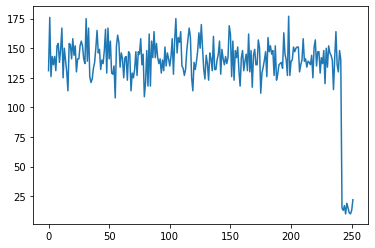

In [1304]:
plt.plot(pred_df.groupby('code_inds')['code_inds'].count())

In [1301]:
pred_df['gene'] = targets[pred_df['code_inds']]
pred_df.loc[:, 'class'] = 1
pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
pred_df.loc[:, 'class'].sum()/len(pred_df)

0.09019129728003715

In [1257]:
pred_df = sel_int_ch(pred_df, code_ref)
pred_df['tot_int'] = pred_df['int_0']+pred_df['int_1']+pred_df['int_2']+pred_df['int_3']
pred_df['tot_int_sig'] = pred_df['int_sig_0']+pred_df['int_sig_1']+pred_df['int_sig_2']+pred_df['int_sig_3']

In [1258]:
from decode_fish.funcs.merfish_eval import make_roc

In [1259]:
def make_roc(df, var='code_err', ascending=True, n_max=30000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['class']==1).sum())
        
    return x, n_blanks

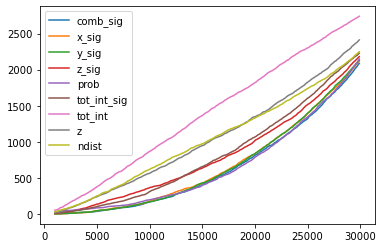

In [1261]:
for k in ['comb_sig','x_sig','y_sig','z_sig','prob','tot_int_sig','tot_int','z']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(pred_df, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()

In [1266]:
keys = ['x_sig','y_sig','z_sig','prob']#,'int_0','int_1','int_2','int_3','int_sig_0','int_sig_1','int_sig_2','int_sig_3']
# pred_df['class'] = pred_df['gene'].str.contains('Blank')*1

In [1267]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

X = np.concatenate([pred_df[keys].values])
y = np.concatenate([pred_df['class'].values])
 
clf = LogisticRegressionCV(random_state=1,max_iter=10000, class_weight='balanced').fit(X, y)

In [1268]:
X = np.concatenate([pred_df[keys].values])
pred_df['score'] = clf.predict_proba(X)[:,1]

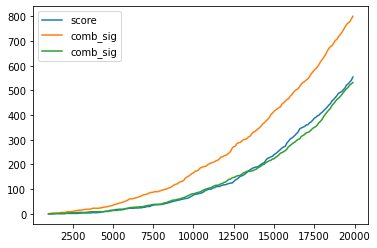

In [1269]:
for df in [pred_df]:
    r  = make_roc(df, 'score', n_max=20000, ascending=True)
    plt.plot(r[0],r[1], label='score')

    r  = make_roc(df, 'comb_sig', n_max=20000, ascending=True)
    plt.plot(r[0],r[1], label='comb_sig')
    
    r  = make_roc(df, 'scorex', n_max=20000, ascending=True)
    plt.plot(r[0],r[1], label='comb_sig')
plt.legend()

In [1270]:
clf.coef_

array([[ 2.76227193e-02,  2.90693219e-02,  4.07585581e-02,
        -2.34277668e+00, -1.58880624e-03]])

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [159]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_2c/n_foci_avg:0xint_fac:1.0xlr:0.00015/train.yaml')

In [160]:
# model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (7, 48, 48)
1 volumes


In [1995]:
# post_proc.samp_threshold = 0.55

In [1145]:
from decode_fish.funcs.exp_specific import read_MOp_tiff
# img = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', scaled=False, z_to_batch=True)
res_df = window_predict(model, post_proc, img, window_size=[None, 128, 128], crop=np.s_[:,:,:,:,:], device='cuda', chrom_map=get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx)[:,:,None], scale=micro.get_ch_mult(), progress_bar=True)
res_df['gene'] = targets[res_df['code_inds']]
print(len(res_df))

torch.Size([7, 22, 1, 2048, 2048])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:11<00:00, 53.03s/it]


85795


In [1146]:
from decode_fish.funcs.merfish_eval import *
bench_df = get_mop_benchmark()
# bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 150)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70

17130008


In [1147]:
# max_p = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
max_p = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]

28656
49829


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]


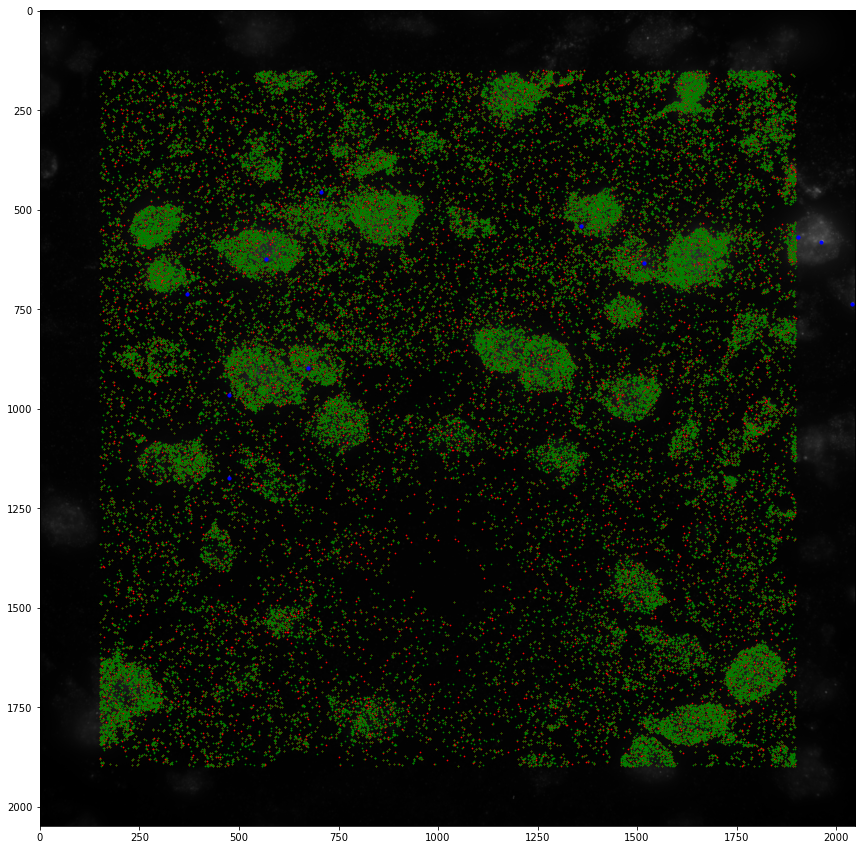

In [1148]:
fids = get_peaks(max_p,18000,20)
# fids['y'] -= 5

plt.figure(figsize=(15,15))
plt.imshow(max_p, cmap='gray')

res_sub = exclude_borders(res_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
bench_sub = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
res_sub = remove_fids(res_sub, px_to_nm(fids), tolerance=1000)
bench_sub = remove_fids(bench_sub, px_to_nm(fids), tolerance=1000)
print(len(bench_sub))
print(len(res_sub))
bench_plt = nm_to_px(bench_sub, [100.,100.,100.])
res_plt = nm_to_px(res_sub, [100.,100.,100.])
plt.scatter(bench_plt['x'], bench_plt['y'], s=0.5, color='red')
plt.scatter(res_plt['x'], res_plt['y'], s=0.5, color='green')

plt.scatter(fids['x'], fids['y'], s=10, color='blue')

In [1149]:
res_sub['z'] = res_sub['z']/100

In [1150]:
res_single = remove_doublets(res_sub, tolerance=200)
print(len(res_single)/len(res_sub))

0.946537157077204


In [1137]:
len(res_single)

48392

In [1151]:
X = np.concatenate([res_single[keys].values])
res_single['score'] = clf.predict_proba(X)[:,1]

/tmp/ipykernel_17125/4042383351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_single['score'] = clf.predict_proba(X)[:,1]


In [1141]:
_,matches,shift = matching(bench_sub, res_single.nsmallest(28000, 'score'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.721
Precision: 0.738
Jaccard: 57.439
RMSE_vol: 48.834
Eff_3d: 50.932
FN: 7986.0 FP: 7330.0
Num. matches: 20670.000
Shift: 6.78,4.37,-0.23


In [343]:
res_single = sel_int_ch(res_single, code_ref)

28656 28000


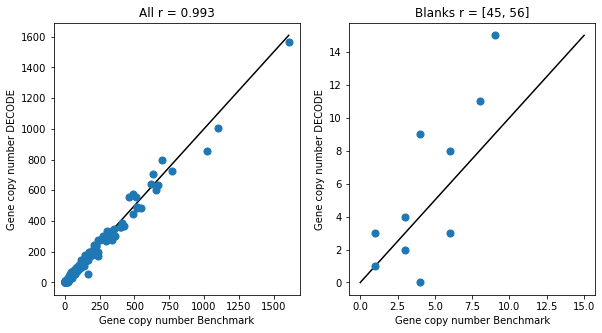

In [1143]:
plot_gene_panels(res_single.nsmallest(28000, 'comb_sig'), bench_sub, targets)

28656 28000


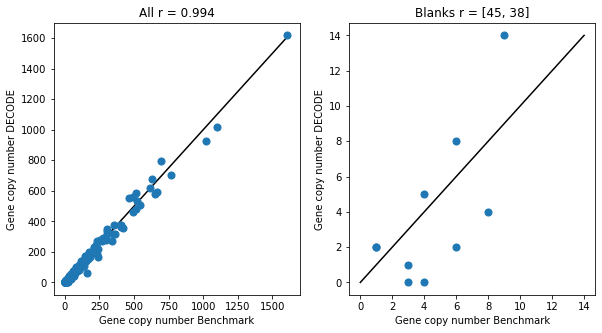

In [1144]:
plot_gene_panels(res_single.nsmallest(28000, 'score'), bench_sub, targets)

28656 28000


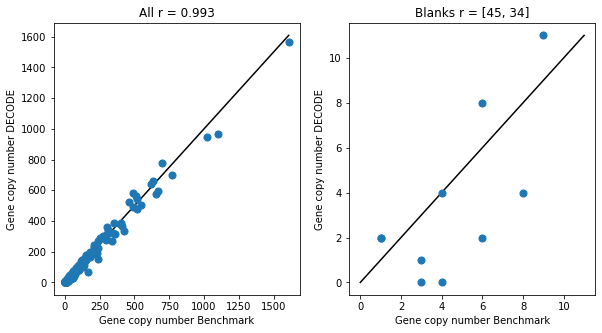

In [1152]:
plot_gene_panels(res_single.nsmallest(28000, 'score'), bench_sub, targets)

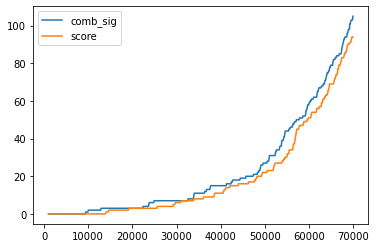

In [1029]:
def make_roc(df, var='code_err', ascending=True, n_max=50000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        
    return x, n_blanks

for k in ['comb_sig','score']:
    r  = make_roc(res_single, k, n_max=70000, ascending=True)
    plt.plot(r[0],r[1], label=k)
plt.legend()

(array([ 6., 13., 10., 10.,  8.,  4.,  6.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <BarContainer object of 7 artists>)

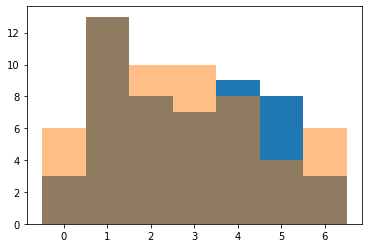

In [320]:
plt.hist(res_single.nsmallest(40000, 'score')[res_single.nsmallest(40000, 'score')['gene'].str.contains('Blank')]['frame_idx'], np.linspace(-0.5,6.5,8))
plt.hist(bench_single[bench_single['gene'].str.contains('Blank')]['frame_idx'], np.linspace(-0.5,6.5,8), alpha=0.5)

In [321]:
for i in range(4):
    for j in range(i+1,4):
        print(i,j,np.corrcoef(res_single[f'int_{i}'], res_single[f'int_{j}'])[0,1])

0 1 0.4579711217044664
0 2 0.3893136296594132
0 3 0.32944347613512387
1 2 0.38923501960689044
1 3 0.3351381382811441
2 3 0.34270125524177547


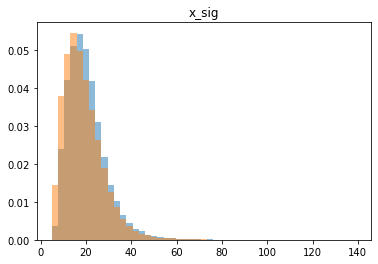

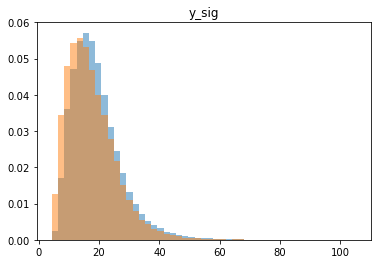

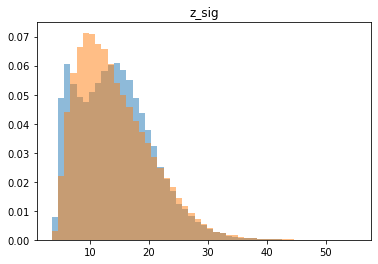

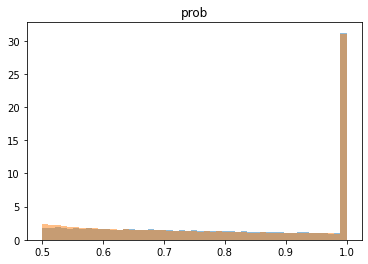

In [325]:
for k in keys:
    plt.hist(pred_df[k], alpha=0.5, bins = np.linspace(pred_df[k].min(),pred_df[k].max(),50), density=True)
    plt.hist(res_single[k], alpha=0.5, bins = np.linspace(pred_df[k].min(),pred_df[k].max(),50), density=True)

    plt.title(k)
    plt.show()

In [329]:
res_c = res_single.nsmallest(36400, 'score')
perf_dict, match_df, shifts = matching(bench_sub, res_c, tolerance=500,)
# res_c = sel_int_ch(res_c, code_ref)

Recall: 0.746
Precision: 0.746
Jaccard: 59.443
RMSE_vol: 50.910
Eff_3d: 52.117
FN: 9252.0 FP: 9263.0
Num. matches: 27137.000
Shift: 1.86,0.09,-0.38


In [330]:
fns = bench_sub.loc[~bench_sub['loc_idx'].isin(match_df['loc_idx_tar'])]
tps = bench_sub.loc[bench_sub['loc_idx'].isin(match_df['loc_idx_tar'])]
fps = res_c.loc[~res_c['loc_idx'].isin(match_df['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.02579503998231197
0.5404236921746649
0.2806866026125445


In [455]:
fn_inds = fns['loc_idx'].values

In [456]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5, size_z=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,int(z):int(z+1), int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

,loc_idx,x,y,z,gene,frame_idx,code_inds
5905250,5905250,799.68341,678.680645,0.0,Grm1,4,95


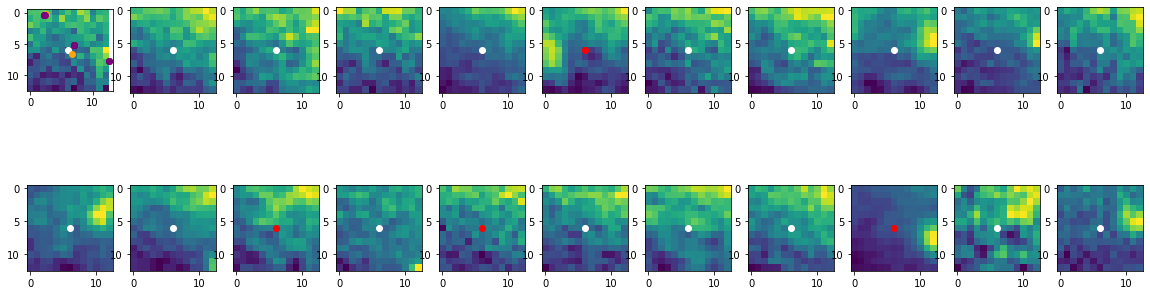

In [457]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]

b_loc = nm_to_px(bench_sub[bench_sub['loc_idx'] == ind], px_size_zyx=[1.2, 100.0, 100.0]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_3d[0][:,:,500:1500,500:1500], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

cropb = crop_df(nm_to_px(bench_sub, px_size_zyx=[1.2, 100.0, 100.0]), crop)
cropr = crop_df(nm_to_px(res_c), crop)
cropf = crop_df(nm_to_px(res_sub), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
    if not i:
        plt.scatter(cropb['x'],cropb['y'],color='orange')
        plt.scatter(cropr['x'],cropr['y'],color='black')
        plt.scatter(cropf['x'],cropf['y'],color='purple')

(4, 6)


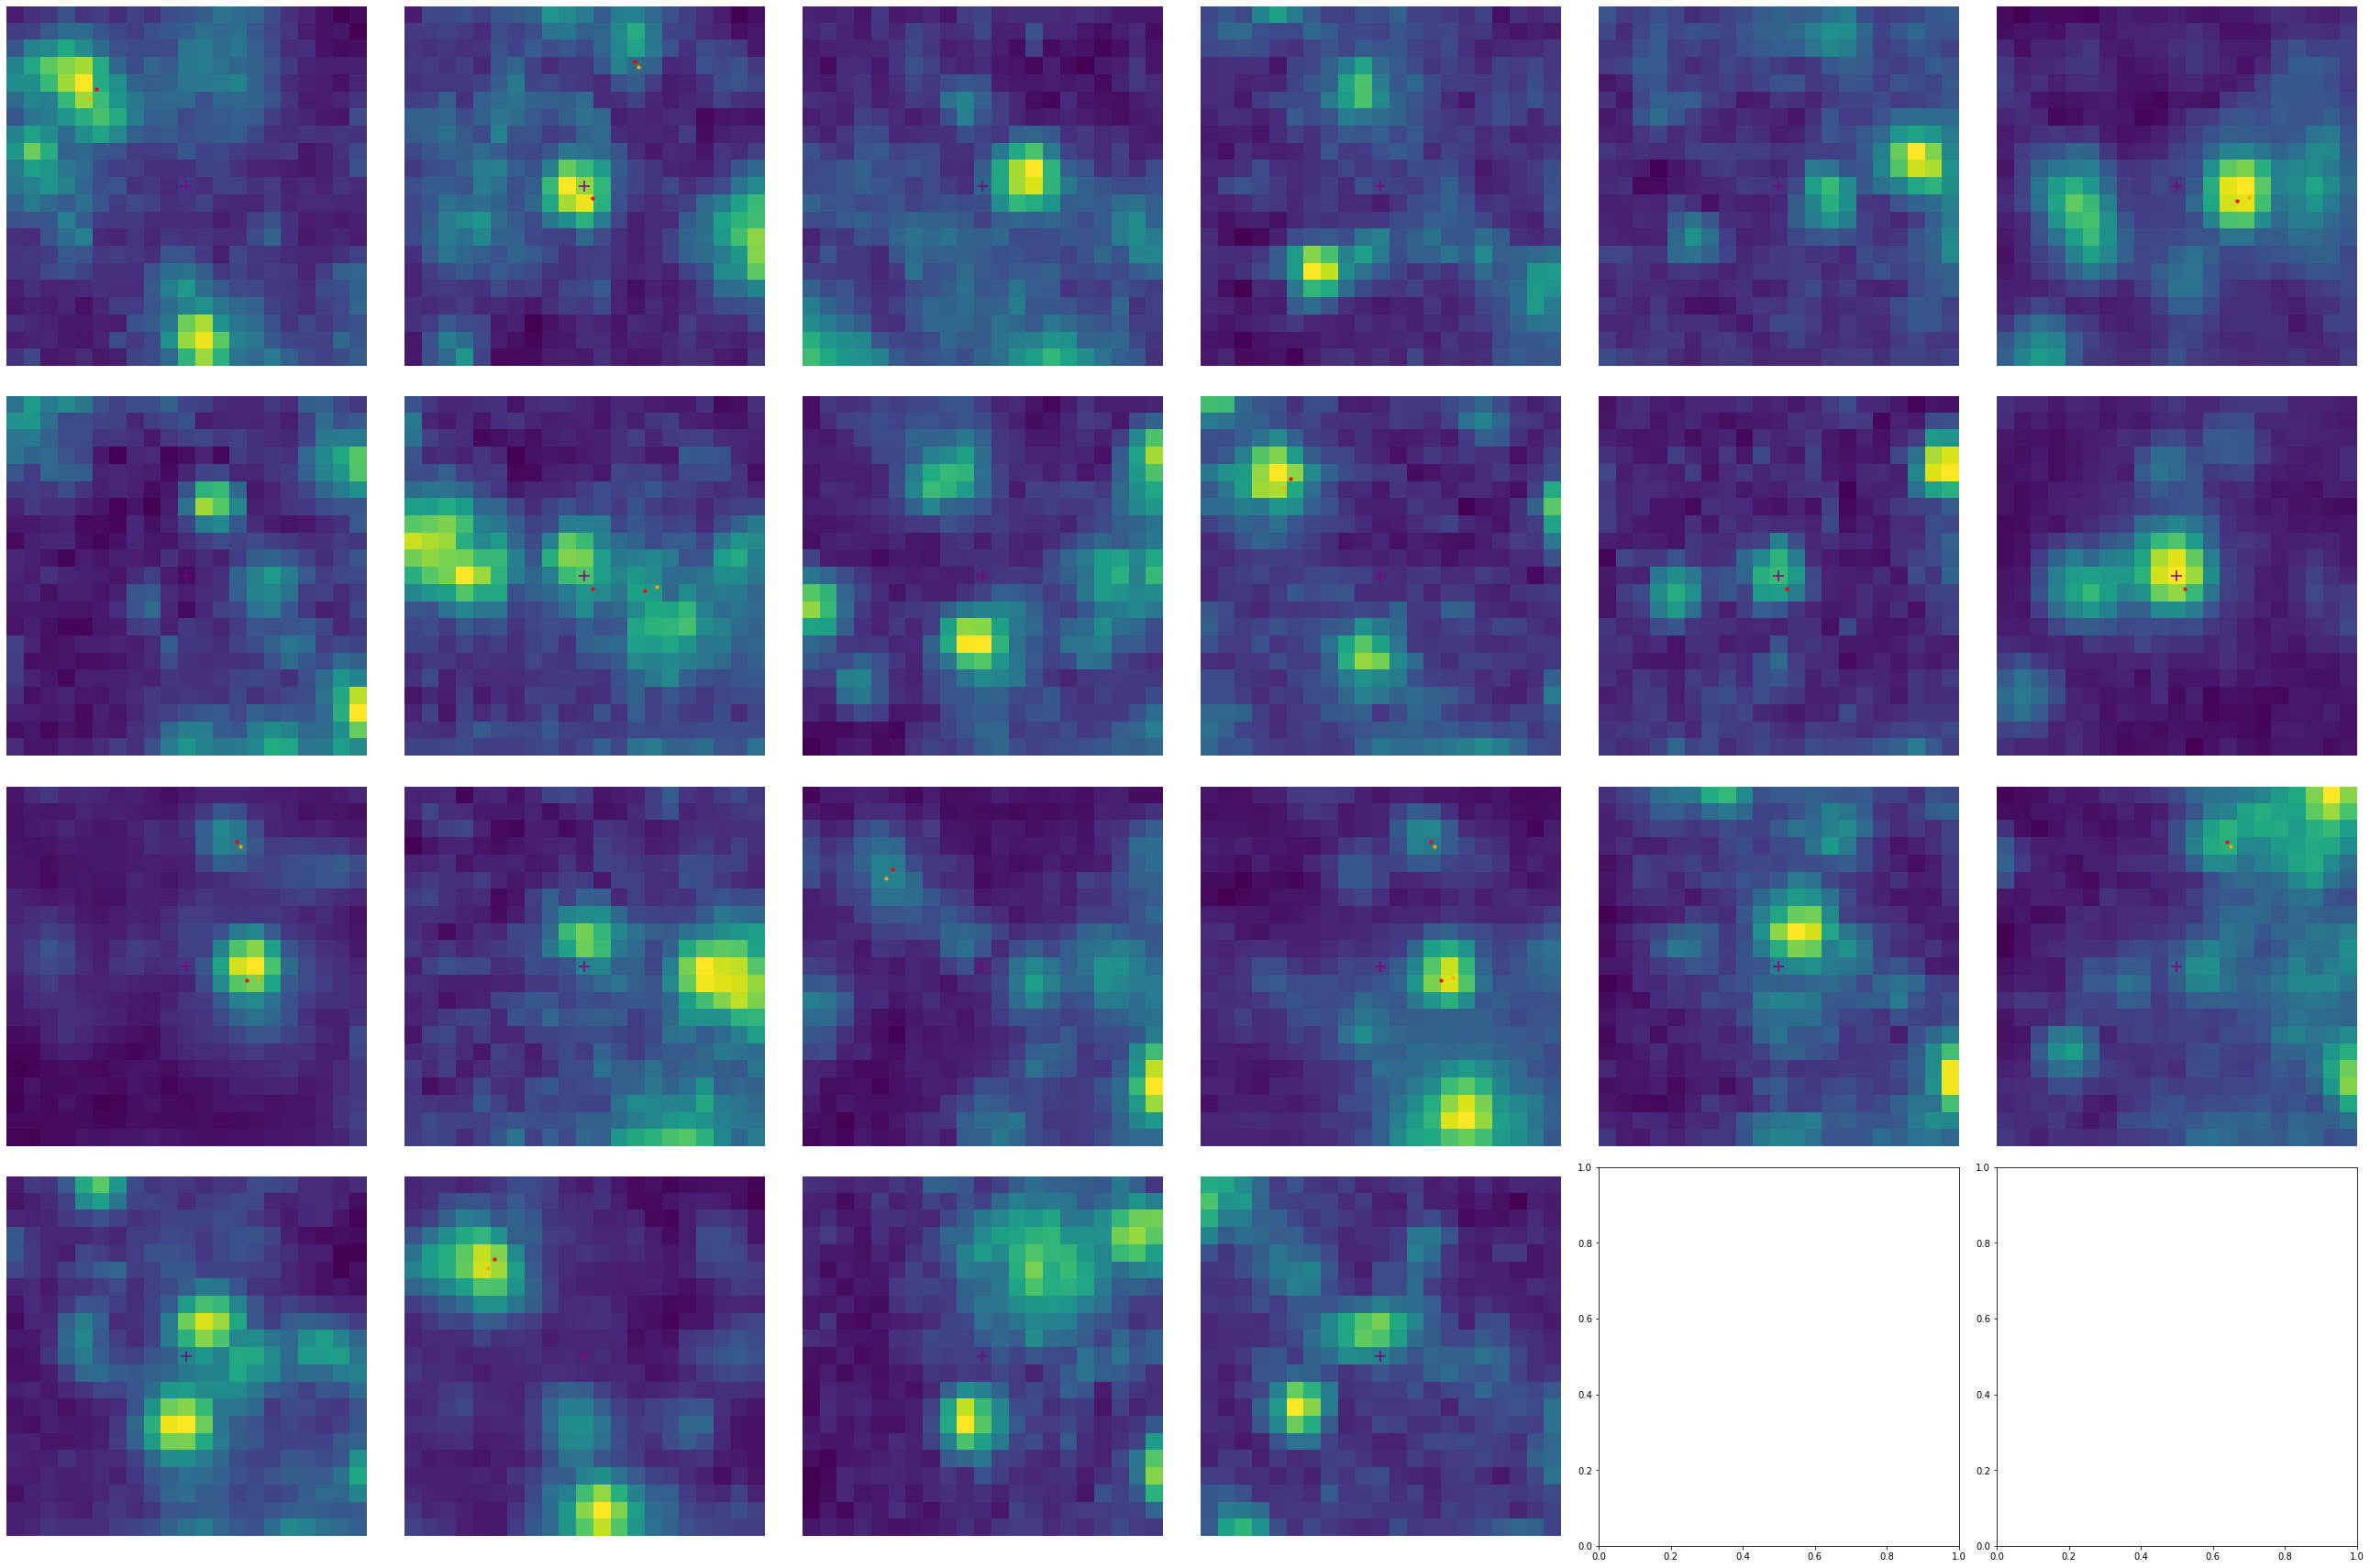

In [175]:
fig, plot_vol, dfs = plot_channels(cpu(img_3d[0][:,:,500:1500,500:1500]), n_rows=4, dfs=[nm_to_px(bench_sub), nm_to_px(res_c)], codebook=code_ref, vmax=None, center=b_loc[['x','y','z']].values, crop_sz=10)

In [176]:
pred_df, rec, res_dict, _, _, _, _ = get_prediction(model, post_proc, torch.tensor(plot_vol).to('cuda'), micro=micro, cuda=True, return_rec=True)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (21) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [177]:
dfs[1]['z'] = 100*dfs[1]['z']
dfs[0]['z'] = 100*dfs[0]['z']

In [178]:
len(pred_df)

3

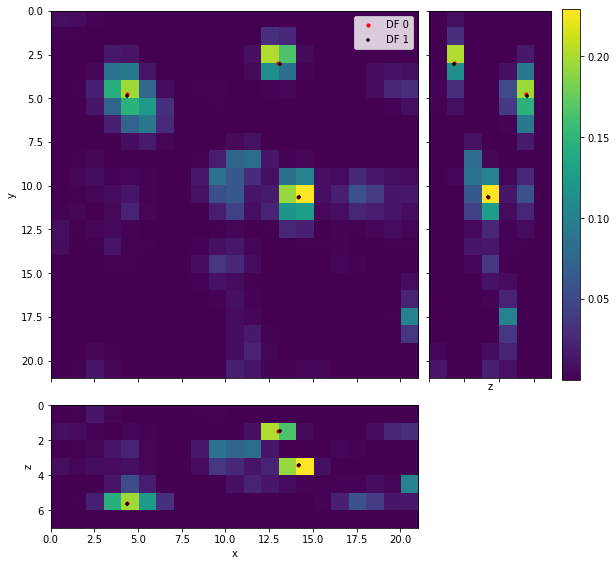

In [179]:
fig,axes = plot_3d_projections(cpu(torch.sigmoid(res_dict['logits']))[0].max(0))
scat_3d_projections(axes, [nm_to_px(pred_df), dfs[1]])

In [879]:
res_blanks = res_sub.nsmallest(50000, 'comb_sig')[res_sub.nsmallest(50000, 'comb_sig')['gene'].str.contains('Blank')]
res_blanks = crop_df(res_sub,np.s_[:,:,116400:117300,47000:47600], shift=False)

print(len(res_blanks))

4244


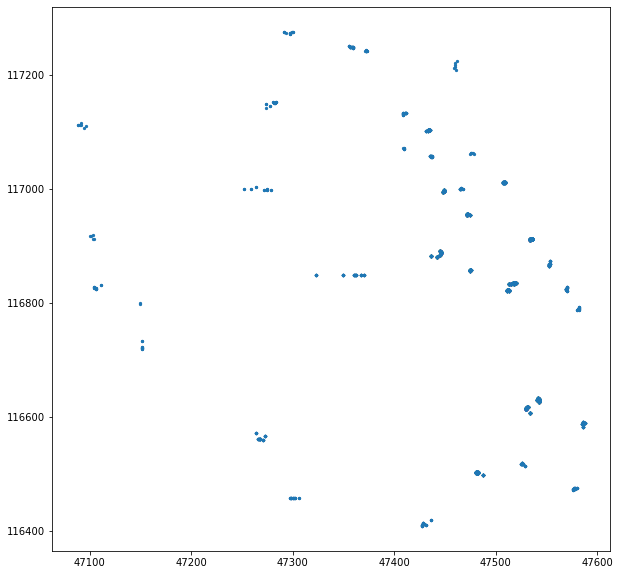

In [869]:
plt.figure(figsize=(10,10))
plt.scatter(res_blanks['x'], res_blanks['y'], s=5)

In [861]:
res_blanks

,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_sig_17,int_18,int_sig_18,int_19,int_sig_19,int_20,int_sig_20,int_21,int_sig_21,gene
10527,10527,0,248,47111.250000,116831.726562,-14.645529,0.583903,15.450480,28.450754,11.843634,...,2.708374,5.045908,1.331240,4.362062,1.501513,2.626412,0.793126,3.153394,1.629272,Blank-7
88947,88947,5,248,47106.386719,116826.867188,-17.630011,0.695484,17.018648,28.566355,11.547043,...,2.290705,5.122998,1.294420,4.310760,1.372110,2.538250,0.754501,2.990518,1.646638,Blank-7
99752,99752,6,248,47104.425781,116825.695312,-17.141766,0.695938,17.030073,29.250626,11.172576,...,2.237415,5.158706,1.361249,4.364566,1.410960,2.663367,0.776816,3.000927,1.699710,Blank-7
42476,42476,2,248,47106.488281,116824.265625,-17.317331,0.752073,17.099897,29.924860,10.911330,...,2.272578,5.236520,1.359706,4.184759,1.391443,2.572942,0.755064,2.934177,1.718408,Blank-7
74717,74717,4,248,47106.734375,116825.351562,-16.733456,0.651162,17.953236,29.993490,11.000784,...,2.208389,5.255607,1.439530,4.366194,1.389895,2.639731,0.763708,2.979174,1.702378,Blank-7
26270,26270,1,248,47104.695312,116827.492188,-14.992952,1.000000,19.697340,29.443586,12.805811,...,2.444175,5.039392,1.413457,4.232057,1.330344,2.861799,0.898063,3.263956,1.656943,Blank-7
74742,74742,4,249,47358.949219,117250.242188,-1.768970,0.503395,53.258575,100.454712,19.931124,...,3.247911,9.556999,3.228783,16.624285,4.455382,12.663283,5.882296,3.593904,3.169237,Blank-8
99777,99777,6,249,47358.363281,117250.000000,-1.820666,0.517665,53.874027,102.003166,19.960817,...,3.234316,9.573074,3.222114,16.573439,4.483756,12.575726,5.810660,3.590490,3.201723,Blank-8
99778,99778,6,249,47459.847656,117220.914062,67.924553,0.589991,111.682083,83.519264,39.058849,...,3.030134,5.623032,2.777677,8.378694,3.951504,5.902955,5.759368,3.445909,4.118799,Blank-8
74743,74743,4,249,47460.062500,117214.843750,68.208794,0.568510,113.411880,83.906479,40.512520,...,2.958022,5.594271,2.819441,8.305253,3.876514,6.046905,5.732403,3.442730,4.142217,Blank-8


In [1021]:
crop_dfs[1]

,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_sig_17,int_18,int_sig_18,int_19,int_sig_19,int_20,int_sig_20,int_21,int_sig_21,gene
9300,9300,0,221,1.281433,1.328308,0.004028,0.509327,9.489947,10.581715,1.967768,...,0.149843,0.972246,0.180238,5.164734,0.366619,0.302573,0.172852,0.463534,0.158416,Timp3
10572,10572,1,0,17.466248,11.145874,0.001434,1.000000,140.963638,171.275375,534.774536,...,6.722933,2.875718,3.521854,5.922774,8.157000,8.228491,5.097352,1.212878,8.350492,1700022I11Rik
10588,10588,1,1,17.402161,12.116791,0.002500,1.000000,49.543606,78.305641,481.520325,...,7.175984,5.458014,3.534497,7.997895,9.190391,17.025394,6.501002,6.953117,9.748475,1810046K07Rik
10623,10623,1,2,17.480957,10.277191,0.002432,0.973765,245.371933,183.505280,572.790649,...,7.274300,3.445449,1.115575,5.407327,5.424988,3.935205,5.175207,0.739879,4.319201,5031425F14Rik
10629,10629,1,3,17.497742,7.426300,-0.001528,0.916772,120.903542,135.837387,286.124817,...,5.267570,4.940122,3.734265,1.680915,3.942463,6.408251,4.069196,5.333775,4.994336,5730522E02Rik
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99762,99762,6,249,16.904541,16.238708,-0.000732,0.594831,47.266979,43.688255,21.728447,...,2.766943,3.639896,1.786607,4.106900,2.005598,3.142137,1.618434,2.059163,1.814538,Blank-8
99780,99780,6,250,17.464294,11.149872,0.001556,1.000000,144.639557,173.063843,542.748291,...,6.756500,2.935061,3.521602,5.900866,8.141515,8.243084,5.075294,1.176407,8.357193,Blank-9
99788,99788,6,251,17.501770,7.417084,-0.001557,0.813168,119.880608,129.779785,287.198761,...,5.341418,5.041490,3.765453,1.737555,3.913983,6.619216,4.082239,5.248881,4.898570,Blank-10
99789,99789,6,251,17.464294,11.149872,0.001556,0.597858,144.639557,173.063843,542.748291,...,6.756500,2.935061,3.521602,5.900866,8.141515,8.243084,5.075294,1.176407,8.357193,Blank-10


(4, 6)


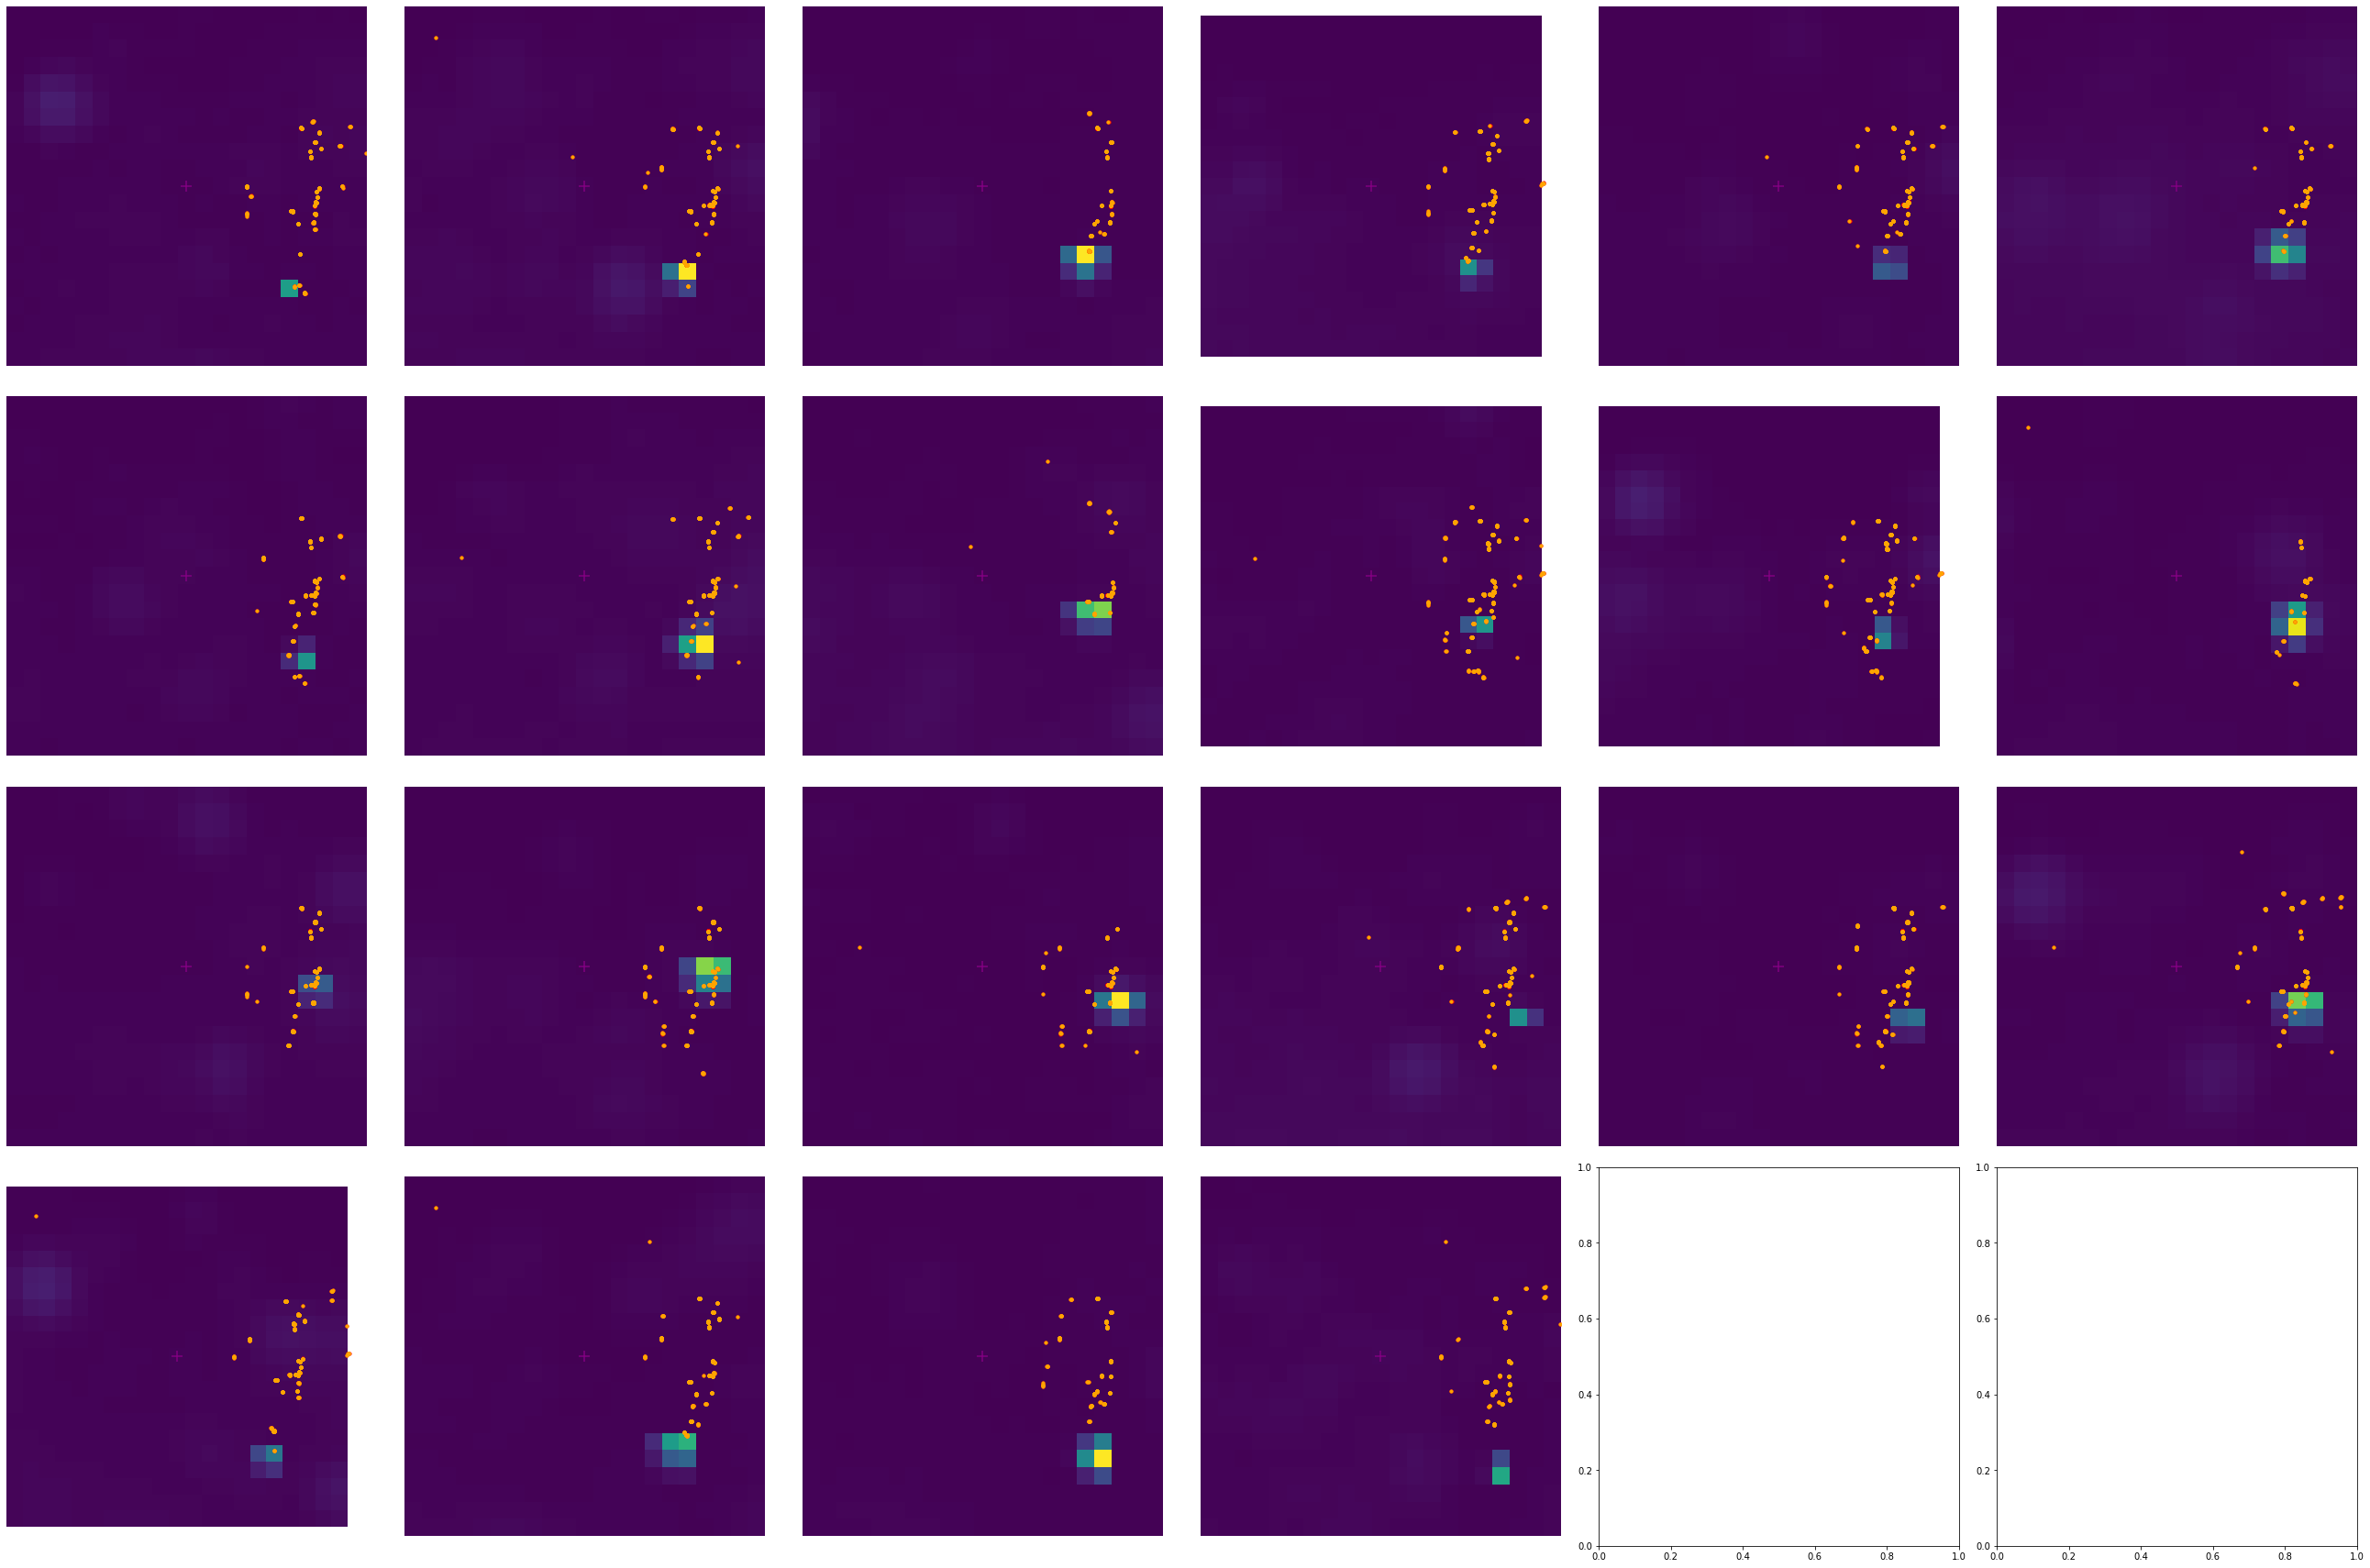

In [1019]:
fig, plot_vol, crop_dfs = plot_channels(img_3d.permute(2,1,0,3,4), n_rows=4, dfs=[nm_to_px(res_sub), nm_to_px(res_clean)], codebook=code_ref, vmax=25000, center=[700, 450, 3])

In [1268]:
tra = sel_int_ch(res_single, code_ref)

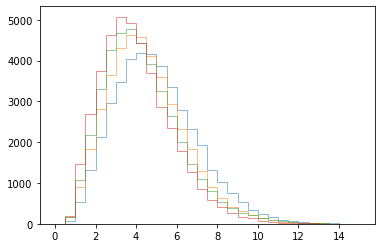

In [1272]:
for i in range(4):
    plt.hist(tra[f'int_{i}'], alpha=0.5, bins=np.linspace(0,15,31), histtype='step')

In [74]:
for i in range(4):
    for j in range(i+1,4):
        print(i, j, np.corrcoef(res_single[f'int_{i}'], res_single[f'int_{j}'])[0,1])

0 1 0.4650975433960784
0 2 0.3934539725254276
0 3 0.3327995589730722
1 2 0.3845068487058609
1 3 0.3377663401786152
2 3 0.34400486801877134


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


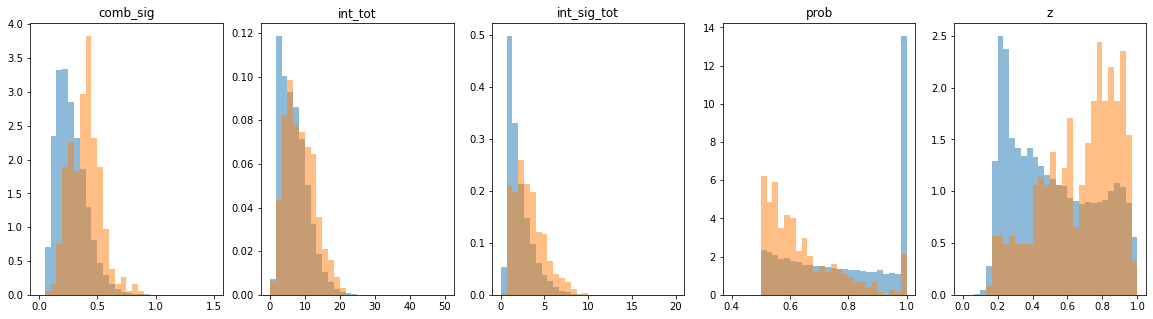

In [378]:
res_df = res_single
int_m = [f'int_{i}' for i in range(4)]
int_s = [f'int_sig_{i}' for i in range(4)]
res_df['int_tot'] = res_df.loc[:,int_m].values.sum(-1)
res_df['int_sig_tot'] = res_df.loc[:,int_s].values.sum(-1)


metrics = ['comb_sig','int_tot','int_sig_tot', 'prob','z']
bins = [np.linspace(0,1.5,31), np.linspace(0,50,31), np.linspace(0,20,31), np.linspace(0.4,1,31), np.linspace(0,1.,31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [112]:
def sel_int_ch(res_df, codebook):
    
    int_m = [f'int_{i}' for i in range(codebook.shape[1])]
    int_s = [f'int_sig_{i}' for i in range(codebook.shape[1])]
    
    int_arr = res_df.loc[:,int_m].values
    int_sig = res_df.loc[:,int_s].values
    
    int_arr[codebook[res_df['code_inds'].values] == 0] = 0.
    int_sig[codebook[res_df['code_inds'].values] == 0] = 0.
    
#     print(int_arr.shape)
    
    ret_df = res_df.drop(columns=int_m)
    ret_df = ret_df.drop(columns=int_s)
    
    ret_df[int_m] = int_arr
    ret_df[int_s] = int_sig

    return ret_df

In [118]:
int_arr = sel_int_ch(res_single.nsmallest(35000, 'score'), code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values

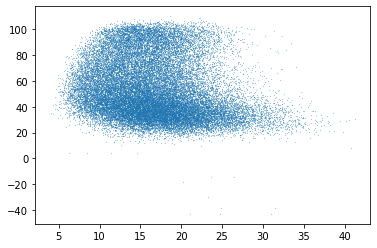

In [119]:
plt.scatter(int_arr.sum(1), res_single.nsmallest(35000, 'score')['z'], s=0.02)

In [120]:
means3 = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]

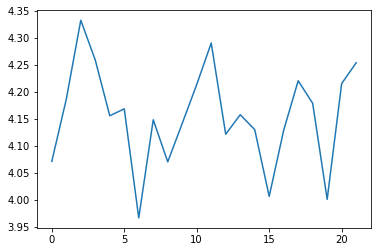

In [121]:
plt.plot(means3)

In [1092]:
import plotly